## Sample transmission example

In this example we will calculate cross-sections and neutron transmission through various metals used for sample holders

## Preamble
Install dependencies and prepare plots. Feel free to edit as you wish:

In [ ]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    from importlib.util import find_spec as _fs
    if not _fs('NCrystal'):
        %pip -q install ncrystal ipympl numpy matplotlib
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009004, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


### Additional modules:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Example #1

Calculate the cross-section and transmission through Inconel. We will model the alloy as a mixture of elemental metals. First we get the cross-section data for each of the elements. For the elements not present in NCrystal we use a constant free atom scattering cross section + 1/v absorption.

This example is based on a transmission experiment planned at ISIS on NaOH. NaOH in liquid form at high temperatures is considered as moderator for compact molten salt reactors. However, NaOH is also corrosive and it is difficult to find sample holder materials that are both sufficiently temperature and corrosion resistant. An additional constraint is that the sample holder should exhibit low neutron absorption and scattering in order to minimize the impact on the measurement. Inconel alloy 625 was found to be a good solution for this problem. More information can also be found in the following paper, https://doi.org/10.1051/epjconf/202328417009.

Text(0, 0.5, 'Micro total cross section [b/atom]')

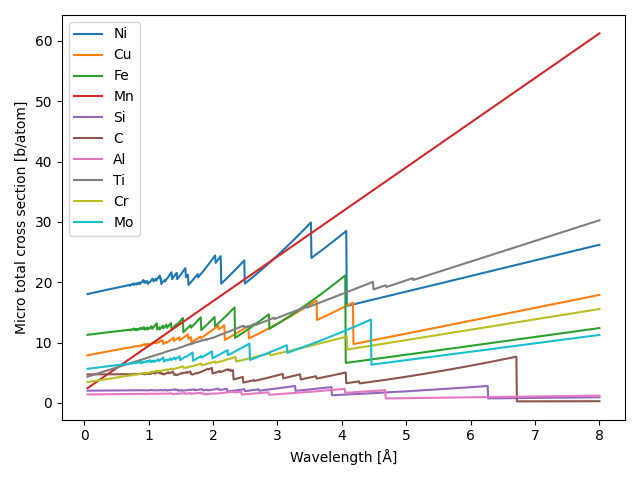

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ncmat_files = {'Ni': 'Ni_sg225.ncmat', 'Cu':'Cu_sg225.ncmat', 'Fe': 'Fe_sg229_Iron-alpha.ncmat', 'Si':'Si_sg227.ncmat', 'C':'C_sg194_pyrolytic_graphite.ncmat',
               'Al':'Al_sg225.ncmat', 'Ti':'Ti_sg194.ncmat', 'Cr':'Cr_sg229.ncmat', 'Mo':'Mo_sg229.ncmat'}

def get_xs(E, element):
  if element in ncmat_files.keys():
    mat = NC.load(ncmat_files[element])
    xs = mat.scatter.xsect(E)+mat.absorption.xsect(E)
  else:
    xs = NC.atomDB(element).freeScatteringXS() + NC.atomDB(element).captureXS()*np.sqrt(25.3e-3/E) # Not yet in NCrystal
  return xs


elements = ['Ni', 'Cu', 'Fe', 'Mn', 'Si', 'C', 'Al', 'Ti', 'Cr', 'Mo']

wl = np.linspace(0.05, 8, 1000)

for element in elements:
  plt.plot(wl, get_xs(NC.wl2ekin(wl), element), label=element)
plt.legend()
plt.xlabel('Wavelength [Å]')
plt.ylabel('Micro total cross section [b/atom]')

Create now a material from the elements and plot the cross-section and transmission.

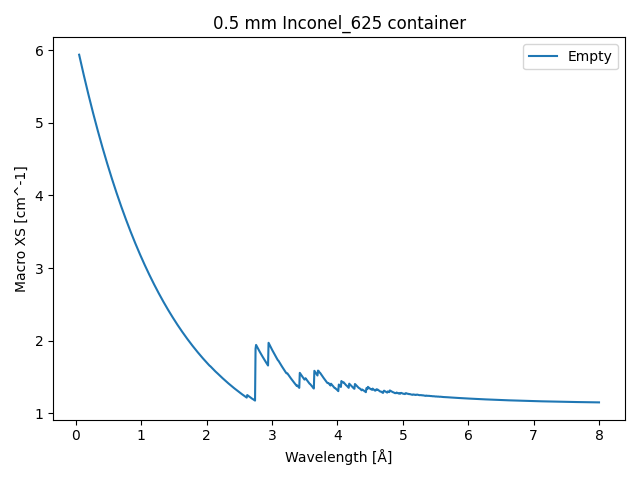

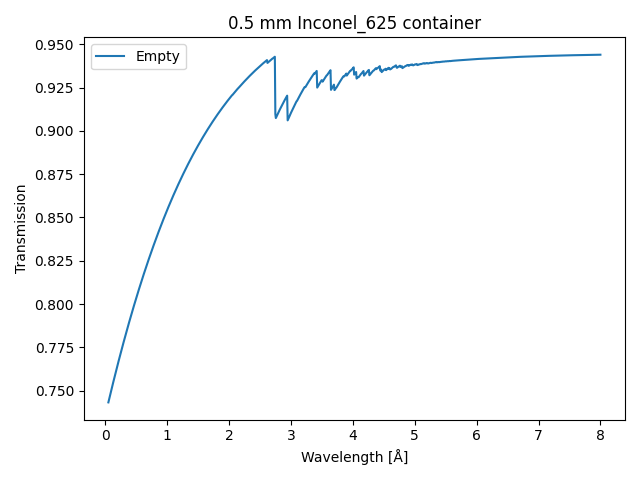

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

material = {'Name': 'Inconel_625', 'Density':8.440, 'Composition':{'Ni': 6.317E-1, 'Cu': 3.333E-3, 'Fe': 5.000E-2, 'Mn': 5.000E-3, 'Si': 5.000E-3, 'C': 1.000E-3, 'Al': 0.000E0, 'Ti': 4.000E-3, 'Cr': 2.000E-1, 'Mo': 1.000E-1}}

container_thickness = 0.05 # cm

xs = np.zeros(len(wl))
for element, fraction in material['Composition'].items():
  N = material['Density']*fraction*NC.constants.constant_avogadro*1e-24/NC.atomDB(element).averageMassAMU()
  xs += N*get_xs(E, element)

plt.plot(wl,xs, label='Empty')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Macro XS [cm^-1]')
plt.title(f'{container_thickness*10} mm {material["Name"]} container')
a = plt.legend()
plt.figure()
plt.plot(wl,np.exp(-xs*container_thickness), label='Empty')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Transmission')
plt.title(f'{container_thickness*10} mm {material["Name"]} container')
a = plt.legend()

## Exercise #1

Compute the cross-section and transmission through Aluminium alloys Al-7075 and Al-6061 based on Table 2 in https://doi.org/10.1016/j.nima.2023.168127

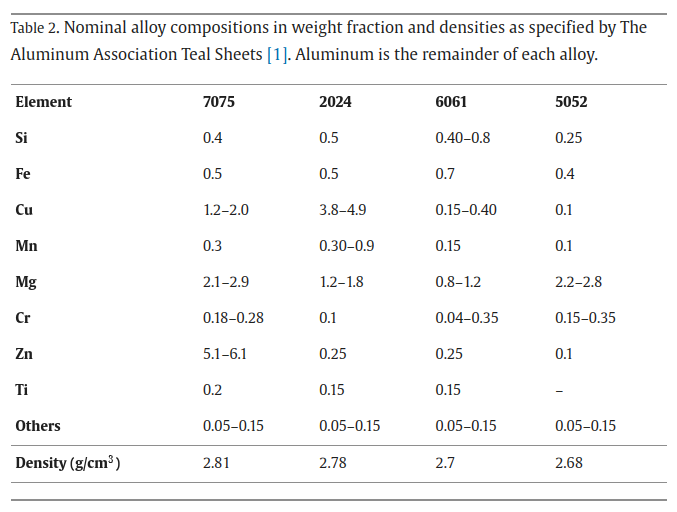

In [ ]:
## Your code